In [1]:
import numpy as np
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
import PIL

# YoloV1 Architecture

In [2]:
# Configuration for the architecture
architecture_config = [
    (3, 64, 1, 1),
    (3, 64, 1, 1),
    "M",
    (3, 128, 1, 1),
    (3, 128, 1, 1),
    "M",
    (3, 256, 1, 1),
    (3, 256, 1, 1),
    "M",
    (3, 512, 1, 1),
    (3, 512, 1, 1),
    "M",
    (3, 256, 1, 1),
    (3, 256, 1, 1),
    "U",
    (3, 128, 1, 1),
    (3, 128, 1, 1),
    "U",
    (3, 64, 1, 1),
    (3, 64, 1, 1),
    "U",
]

In [3]:
# Define a CNN block that includes convolution, batch normalization, and LeakyReLU activation
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        # Define a convolutional layer without bias
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        # Define a batch normalization layer
        self.batchnorm = nn.BatchNorm2d(out_channels)
        # Define a LeakyReLU activation function with negative slope 0.1
        self.leakyrelu = nn.LeakyReLU(0.1)

    # Define the forward pass
    def forward(self, x):
        # Apply convolution, batch normalization, and LeakyReLU sequentially
        return self.leakyrelu(self.batchnorm(self.conv(x)))

In [4]:
# Define the YOLOv1 neural network model
class Yolov1(nn.Module):
    def __init__(self, in_channels=1, architecture = architecture_config, split_size=5, num_boxes=2, num_classes=75, **kwargs):
        super(Yolov1, self).__init__()
        # Set the architecture configuration
        self.architecture = architecture
        # Set the number of input channels
        self.in_channels = in_channels

        self.S = split_size
        self.B = num_boxes
        self.C = num_classes
        
        # Create the convolutional layers (Darknet)
        self.darknet = self._create_conv_layers(self.architecture)
        # Create the fully convolution layers
        self.fcn = self._create_fcn(**kwargs)

        

    # Define the forward pass
    def forward(self, x):
        # Pass through the convolutional layers
        x = self.darknet(x)
        # Flatten the output and pass through the fully connected layers
        # return self.fcs(torch.flatten(x, start_dim=1))
        x = self.fcn(x)
        x = nn.functional.interpolate(x, size=(self.S, self.S), mode='area')
        x = x.view(x.size(0),-1)
        
        return x
    
    # Method to create convolutional layers based on the architecture configuration
    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                # Add a convolutional block for each tuple in the architecture
                layers += [
                    CNNBlock(
                        in_channels, out_channels=x[1], kernel_size=x[0], stride=x[2], padding=x[3]
                    )
                ]
                # Update the number of input channels
                in_channels = x[1]

            elif type(x) == str:
                # Add a max pooling layer for each "M" in the architecture
                if x == "M":
                    layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
                elif x == "U":
                    layers += [nn.Upsample(scale_factor=2, mode='nearest')]
            
            elif type(x) == list:
                # Handle repeating blocks in the architecture
                conv1 = x[0] # First tuple in the list
                conv2 = x[1] # Second tuple in the list
                num_repeats = x[2] # Number of repeats

                for _ in range(num_repeats):
                    # Add the repeated convolutional blocks
                    layers += [
                        CNNBlock(
                            in_channels, out_channels=conv1[1], kernel_size=conv1[0], stride=conv1[2], padding=conv1[3]
                        )
                    ]
                    layers += [
                        CNNBlock(
                            in_channels=conv1[1], out_channels=conv2[1], kernel_size=conv2[0], stride=conv2[2], padding=conv2[3]
                        )
                    ]
                    # Update the number of input channels
                    in_channels = conv2[1]
        
        # Return the sequential container of layers
        return nn.Sequential(*layers)


    # Fully convolutional layers to replace fully connected layers
    def _create_fcn(self):
        layers = []
        In_Ch = 64
        Out_Ch = self.C + self.B * 5
        architecture = [
            (3, Out_Ch, 1, 1),
            (3, Out_Ch, 1, 1), 
                        ]
        for x in architecture:
            if type(x) == tuple:
                layers += [
                            CNNBlock(
                                in_channels=In_Ch, out_channels=x[1], kernel_size=x[0], stride=x[2], padding=x[3]
                            )
                        ]
                # Update the number of input channels
                In_Ch = x[1]
        return nn.Sequential(*layers)

# Model Testing

In [5]:
! nvidia-smi

Tue Jul  2 16:05:50 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    Off |   00000000:01:00.0  On |                  N/A |
| 33%   51C    P3             31W /  220W |    3469MiB /  12282MiB |     10%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [7]:
main_architecture = architecture_config
def test(image, In_Ch=1, S=5, B=2, C=75):
    # Initializes the Yolov1 model with grayscale input (1 channel), grid size S=5, 2 bounding boxes per grid cell, and 75 classes.
    model = Yolov1(in_channels=In_Ch, architecture=main_architecture, split_size=S, num_boxes=B, num_classes=C).to(DEVICE)
    model.eval()  # Set the model to evaluation mode to deactivate dropout layers and batch normalization layers
    with torch.no_grad():  # Disable gradient calculation for inference
        images = image.to(DEVICE)  # Move the images to the appropriate device (CPU or GPU)
        print(f"images.size() = {images.size()}")
        outputs = model(images)  # Get the model's predictions
        print(outputs.shape)  # Print the shape of the output tensor

# Call the test function with the train_loader
x = torch.randn((10, 1, 300, 300))
test(image=x)

images.size() = torch.Size([10, 1, 300, 300])
torch.Size([10, 2125])


# Loss Function

In [8]:
from utils_Yolov1 import intersection_over_union

class YoloLoss(nn.Module):
    def __init__(self, S=5, B=2, C=75):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")
        self.S = S
        self.B = B
        self.C = C
        self.weight = [5, 1, 0.5, 1]

    def forward(self, predictions, target):
        # Reshape predictions
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Calculate IoU for each bounding box
        iou_box_list = []
        for b in range(self.B):
            iou_b = intersection_over_union(predictions[..., self.C + 1 + b * 5:self.C + 5 + b * 5], 
                                            target[..., self.C + 1:self.C + 5])
            iou_box_list.append(iou_b)

        # Stack IoUs and find the best box index for each cell
        ious = torch.stack(iou_box_list, dim=0)  # Shape: (B, N, S, S)
        iou_maxes, best_box = torch.max(ious, dim=0)  # Shape: (N, S, S)
        exists_box = target[..., self.C].unsqueeze(3) # Iobj_i

        # Calculate box predictions
        # best_box = best_box.unsqueeze(-1)  # Shape: (N, S, S, 1)
        box_predictions = torch.zeros_like(predictions[..., self.C + 1:self.C + 5])
        for b in range(self.B):
            box_predictions += (best_box == b).float() * predictions[..., self.C + 1 + b * 5:self.C + 5 + b * 5]

        # Apply exists_box mask
        box_predictions = exists_box * box_predictions
        box_targets = exists_box * target[..., self.C + 1:self.C + 5]

        # Adjust box predictions and targets
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        # ================ #
        #   FOR BOX LOSS   #
        # ================ #

        # (N, S, S, 4) -> (N*S*S, 4)
        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2)
        )

        # =================== #
        #   FOR OBJECT LOSS   #
        # =================== #

        pred_box = torch.zeros_like(predictions[..., self.C:self.C + 1])
        for b in range(self.B):
            pred_box += (best_box == b).float() * predictions[..., self.C + b * 5:self.C + 1 + b * 5]

        # Apply exists_box mask
        pred_box = exists_box * pred_box

        # Calculate object loss
        object_loss = self.mse(
            torch.flatten(pred_box),
            torch.flatten(exists_box * target[..., self.C:self.C + 1]),
        )

        # ====================== #
        #   FOR NO OBJECT LOSS   #
        # ====================== #

        # (N, S, S, 1) -> (N, S*S*1)
        no_object_loss = sum(
            [
                self.mse(
                    torch.flatten((1 - exists_box) * predictions[..., self.C + i * 5:self.C + 1 + i * 5], start_dim=1),
                    torch.flatten((1 - exists_box) * target[..., self.C:self.C + 1], start_dim=1),
                )
                for i in range(self.B)
            ]
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        # (N, S, S, C) -> (N*S*S, C)
        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :self.C], end_dim=-2),
            torch.flatten(exists_box * target[..., :self.C], end_dim=-2),
        )

        # Combine all losses
        loss = (
            self.weight[0] * box_loss
            + self.weight[1] * object_loss
            + self.weight[2] * no_object_loss
            + self.weight[3] * class_loss
        )

        return loss



# DataSet amd Implementation
The following cell loads an NPY file which contains
* `IMG`: a 300x300 image each of which has a hiragana and kanjis,
* `LABEL`: the hiragana class ID in each image,
* `MOJI`: the hiragana in each image, and
* `BBOX`: the bounding box $(X, Y, W, H)$ of the hiragana in each image. $(X, Y$) and $(X+W, Y+H)$ denote the top-left and bottom-right corner respectively.

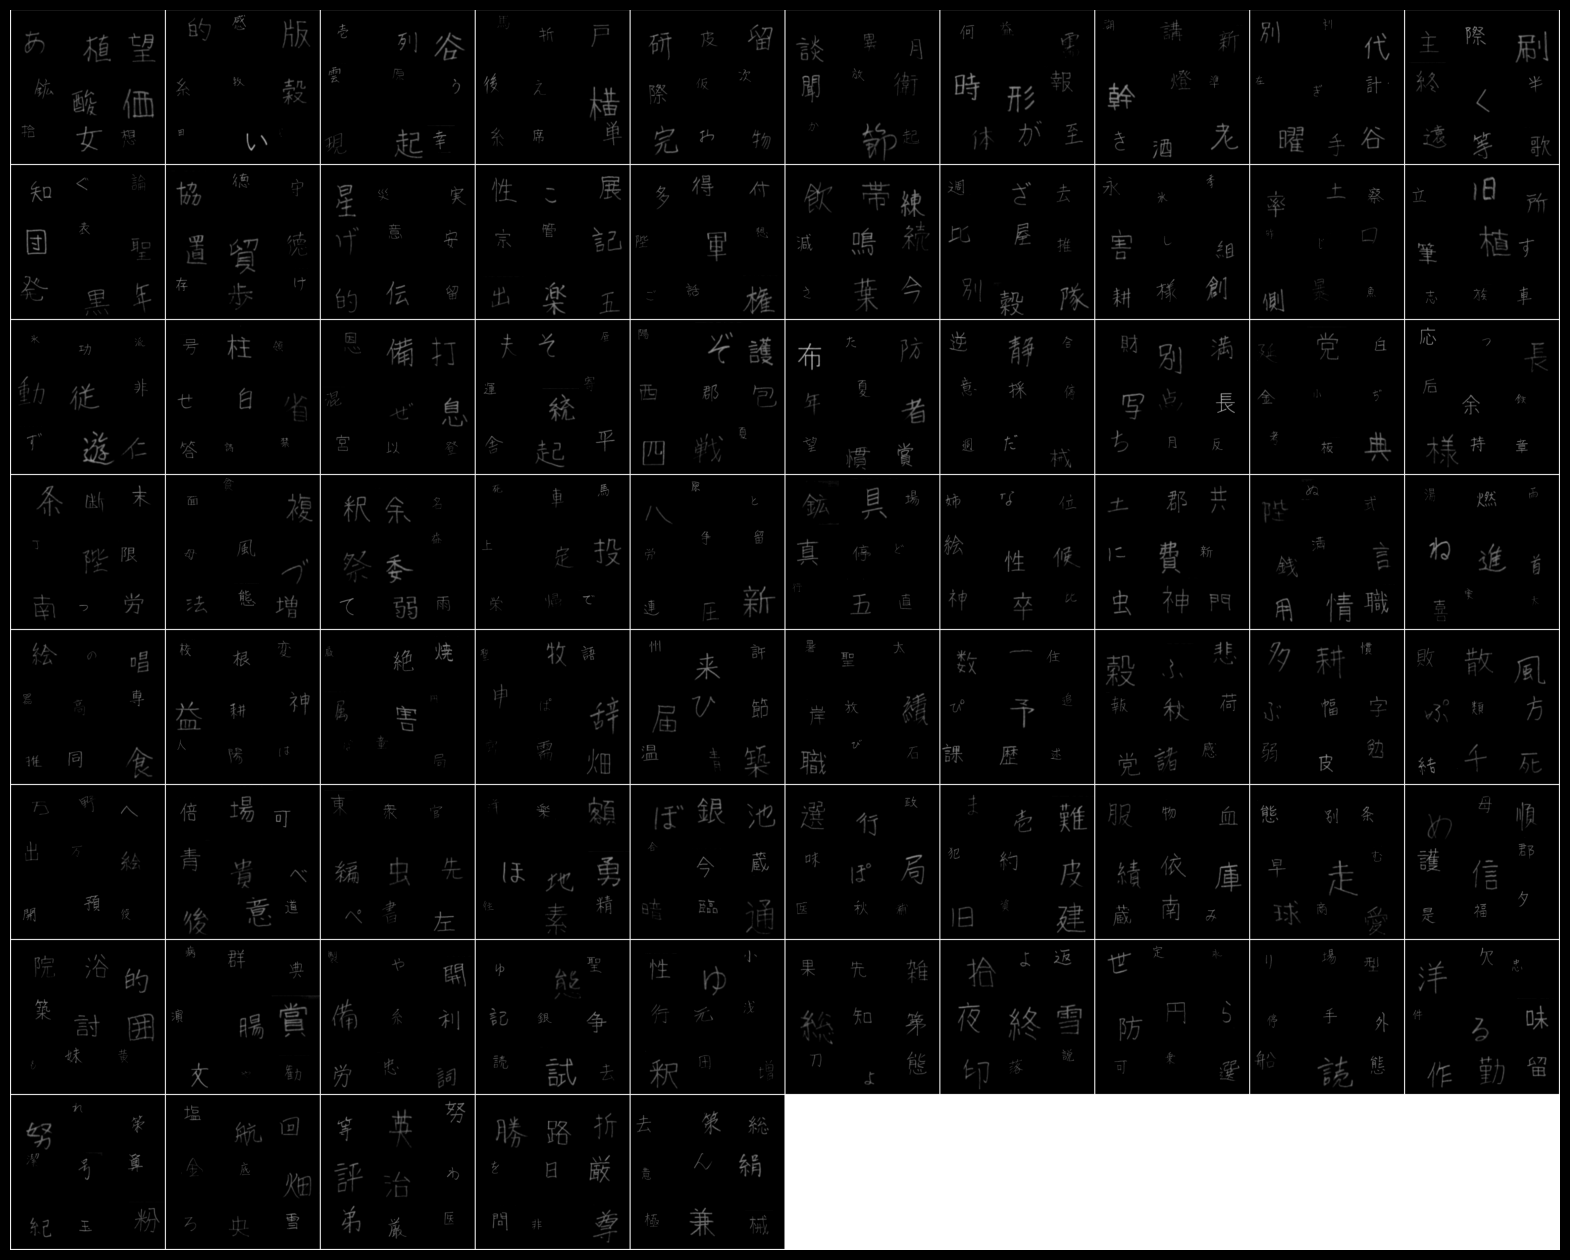

MOJI = き


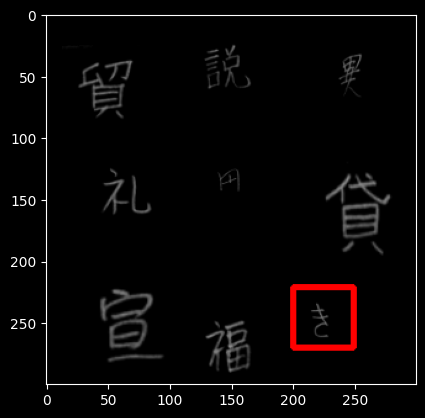

In [9]:
folder_path = f"/home/jhongfongfah/PYTORCH_PROJ/[Hong] week04"

SKIP=10
assert 160 % SKIP == 0

DATA = np.load(f'{folder_path}/Practice_DNN/ETL8G_300x300.npz')

# 300x300 images, 75 hiragana classes, 16 images per class
IMG = DATA['img']

# the label [0:74] of each image.
LABEL = DATA['label'].astype(np.int64)

# the hiragana in each image
MOJI = DATA['moji']

# the bounding box (X, Y, W, H) of the hiragana in each image (X and Y defines the top-left corner of the box in the image)
BBOX = DATA['bbox']
# Normalize BBOX coordinates
norm_BBOX = BBOX.astype(np.float32).copy()
norm_BBOX[:, 0] /= IMG[0,...].shape[-2]  # Normalize X by image width
norm_BBOX[:, 1] /= IMG[0,...].shape[-1]  # Normalize Y by image height
norm_BBOX[:, 2] /= IMG[0,...].shape[-2]  # Normalize W by image width
norm_BBOX[:, 3] /= IMG[0,...].shape[-1]  # Normalize H by image height

if SKIP > 1:
    IMG = IMG[::SKIP,:,:]
    LABEL = LABEL[::SKIP]
    MOJI = MOJI[::SKIP]
    BBOX = BBOX[::SKIP]
    norm_BBOX = norm_BBOX[::SKIP]

# show thumbnails
plt.figure(figsize=(20.0, 20.0))
grid = torchvision.utils.make_grid(torch.from_numpy(IMG[::160//SKIP,None,:,:].astype(float) / 255), nrow=10, pad_value=1)
plt.imshow(grid.clamp(0, 1).permute(1, 2, 0).expand(-1, -1, 3).cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()


def show_image_bbox(ax, gray_img, bbox):
    if np.max(gray_img) <= 1.0:
        gray_img = gray_img * 255
    bgr = cv2.cvtColor(gray_img.astype(np.uint8), cv2.COLOR_GRAY2BGR)
    bgr = cv2.rectangle(bgr, (bbox[0], bbox[1]), (bbox[0]+bbox[2], bbox[1]+bbox[3]), (255, 0, 0), 3)
    ax.imshow(bgr)


# show an image with bbox
idx = 123
print(f"MOJI = {MOJI[idx]}")
fig, ax = plt.subplots(1,1)
show_image_bbox(ax, IMG[idx], BBOX[idx])
plt.show()

In [10]:
# Split the data
from sklearn.model_selection import train_test_split
I_train, I_test, L_train, L_test, B_train, B_test, M_train, M_test, norm_B_train, norm_B_test = train_test_split(IMG, LABEL, BBOX, MOJI, norm_BBOX)
print('IMG  : ', I_train.shape, I_test.shape)
print('LABEL: ', L_train.shape, L_test.shape)
print('BBOX: ', B_train.shape, B_test.shape)
print('MOJI: ', M_train.shape, M_test.shape)
print('norm_BBOX: ', norm_B_train.shape, norm_B_test.shape)

I_train = I_train.astype(np.float32)
I_test = I_test.astype(np.float32)
L_train = L_train.astype(np.int64)
L_test = L_test.astype(np.int64)
norm_B_train = norm_B_train.astype(np.float32)
norm_B_test = norm_B_test.astype(np.float32)

IMG  :  (900, 300, 300) (300, 300, 300)
LABEL:  (900,) (300,)
BBOX:  (900, 4) (300, 4)
MOJI:  (900,) (300,)
norm_BBOX:  (900, 4) (300, 4)


In [11]:
class CustomTensorDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, moji, norm_bboxes, S=5, B=2, C=75, transform=None):
        # Initialize the dataset with images, labels, and normalized bounding boxes.
        # S is the grid size, B is the number of bounding boxes per grid cell,
        # C is the number of classes, and transform is an optional transformation.
        self.images = images
        self.labels = labels
        self.moji = moji
        self.bboxes = norm_bboxes
        self.S = S
        self.B = B
        self.C = C
        self.transform = transform

        # Ensure labels are expanded to have an additional dimension
        self.labels = np.expand_dims(self.labels, axis=1)
        # Concatenate the labels and bounding boxes to create a combined representation
        self.boxes = np.concatenate((self.labels, self.bboxes), axis=1)

    def __getitem__(self, index):
        # Retrieve the image and boxes for a given index
        img = self.images[index]
        boxes = self.boxes[index]
        moji = self.moji[index]

        # Convert boxes to tensor
        boxes = torch.tensor(boxes, dtype=torch.float32)

        # Apply transformations if provided
        if self.transform:
            img = self.transform(PIL.Image.fromarray(img))
        else:
            img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # Ensure img is converted to a tensor if no transform

        # Create an empty label matrix of size (S, S, C + 5 * B)
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
        # Parse the class label and bounding box coordinates
        class_label, x, y, width, height = boxes.tolist()
        center_x = x + width / 2
        center_y = y + height / 2
        class_label = int(class_label)
        # Calculate the grid cell coordinates
        i, j = int(self.S * center_y), int(self.S * center_x)
        x_cell, y_cell = self.S * center_x - j, self.S * center_y - i
        width_cell, height_cell = (
            width * self.S,
            height * self.S,
        )

        # If the cell doesn't already have an object, add the object to the cell
        if label_matrix[i, j, self.C] == 0:
            label_matrix[i, j, self.C] = 1  # Indicate presence of an object
            box_coordinates = torch.tensor(
                [x_cell, y_cell, width_cell, height_cell]
            )
            # Assign the bounding box coordinates and class label
            label_matrix[i, j, self.C+1:self.C+5] = box_coordinates
            label_matrix[i, j, class_label] = 1
        return img, label_matrix, moji

    def __len__(self):
        # Return the total number of images in the dataset
        return self.images.shape[0]


# Training and Evaluation

In [12]:
from utils_Yolov1 import (
    mean_average_precision,
    get_bboxes,
    cellboxes_to_boxes,
    plot_image,
    plot_image_pred_target,
    non_max_suppression,
)

# Hyperparameters etc.
LEARNING_RATE = 2e-5
BATCH_SIZE = 16
WEIGHT_DECAY = 1e-5
EPOCHS = 100

S = 1
B = 2
C = 75
IOU_THRESHOLD = 0.5

# Data loader
def get_dataloader(images, labels, moji, norm_bboxes, batch_size=128, shuffle=True, device=None):
    uses_cuda = False if device is None else device.type == 'cuda'
    dataset = CustomTensorDataset(images, labels, moji, norm_bboxes, S=S, B=B, C=C, transform=transform)
    return torch.utils.data.DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=4 if uses_cuda else 0,
            pin_memory=uses_cuda  # True if CUDA
            )

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

train_loader = get_dataloader(I_train, L_train, M_train, norm_B_train, batch_size=BATCH_SIZE, device=DEVICE)
test_loader = get_dataloader(I_test, L_test, M_test, norm_B_test, batch_size=BATCH_SIZE, device=DEVICE)

# Printing DataLoader contents
for img, label_matrix, _ in train_loader:
    print(f"img = {img.shape}")
    print(f"label_matrix = {label_matrix.shape}")
    break

img = torch.Size([16, 1, 300, 300])
label_matrix = torch.Size([16, 7, 7, 85])


In [13]:
def calculate_mAP(loader, model, iou_threshold = 0.5, threshold = 0.4, S=5, B=2, C=7):
    pred_boxes, target_boxes = get_bboxes(
            loader, model, iou_threshold, threshold, S, B, C
        )

    mean_avg_prec = mean_average_precision(
        pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
    )
    # print(f"mAP: {mean_avg_prec:.4f}")
    return mean_avg_prec

In [14]:
OUTNAME = f'{folder_path}/My_Code/DNN_02_FCN_output'
model = Yolov1(in_channels=1, architecture=main_architecture, split_size=S, num_boxes=B, num_classes=C).to(DEVICE)
optimizer = torch.optim.Adam(
    model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY
)
loss_fn = YoloLoss(S=S,B=B,C=C)

iou_threshold = 0.5
train_threshold = 0.4
test_threshold = 0.2

train_losses = []
test_losses = []
train_mAP_list = []
train_accuracies = []
test_mAP_list = []
test_accuracies = []

for epoch in range(EPOCHS):
    # print(f"Epoch [{epoch + 1}/{EPOCHS}]")

    model.train()  # Ensure the model is in training mode.
    loop = tqdm(train_loader, desc='Train Epoch: %d' % epoch, unit='batches')
    train_mean_loss = []
    train_correct_sum = 0
    train_correct_count = 0
    train_input_count = 0
    for x, y, _ in loop:
        train_input_count += 1
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        train_mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = []
        target = []
        for idx in range(out.size(0)):
            pred_bboxes = cellboxes_to_boxes(out, S, B, C)
            pred_bboxes = non_max_suppression(pred_bboxes[idx], iou_threshold, box_format="midpoint")
            pred_class = int(pred_bboxes[0][0])
            pred.append(pred_class)

            target_bboxes = cellboxes_to_boxes(y, S, B, C)
            target_bboxes = non_max_suppression(target_bboxes[idx], iou_threshold, box_format="midpoint")
            target_class = int(target_bboxes[0][0])
            target.append(target_class)

        # Compute the number of correct predictions
        pred_tensor = torch.tensor(pred).to(DEVICE)
        target_tensor = torch.tensor(target).to(DEVICE)
        correct = (pred_tensor == target_tensor).sum().item()
        train_correct_sum += correct
        train_correct_count += out.size(0)
        
        # update progress bar
        train_loss = sum(train_mean_loss)/len(train_mean_loss)

        # update progress bar
        train_loss= sum(train_mean_loss)/len(train_mean_loss)
        if train_input_count == len(train_loader): 
            train_mAP = calculate_mAP(train_loader,model,iou_threshold,train_threshold,S,B,C)
            train_class_accuracy = train_correct_sum / train_correct_count
        else:
            train_mAP = 0
            train_class_accuracy = 0
        loop.set_postfix(loss=f"{train_loss:.2f}", Train_mAP = f"{train_mAP:.4f}", class_accuracy = f"{train_class_accuracy:.4f}")
    train_losses.append(train_loss)
    train_mAP_list.append(train_mAP)
    train_accuracies.append(train_accuracies)

    model.eval()
    test_mean_loss = []
    test_correct_sum = 0
    test_correct_count = 0
    test_input_count = 0
    with torch.no_grad():
        loop = tqdm(test_loader, desc='Test', unit='batches')
        test_mean_loss = []
        for x, y, _ in loop:
            test_input_count += 1
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = loss_fn(out, y)
            test_mean_loss.append(loss.item())


            pred = []
            target = []
            for idx in range(out.size(0)):
                pred_bboxes = cellboxes_to_boxes(out, S, B, C)
                pred_bboxes = non_max_suppression(pred_bboxes[idx], iou_threshold, box_format="midpoint")
                pred_class = int(pred_bboxes[0][0])
                pred.append(pred_class)

                target_bboxes = cellboxes_to_boxes(y, S, B, C)
                target_bboxes = non_max_suppression(target_bboxes[idx], iou_threshold, box_format="midpoint")
                target_class = int(target_bboxes[0][0])
                target.append(target_class)

            # Compute the number of correct predictions
            pred_tensor = torch.tensor(pred).to(DEVICE)
            target_tensor = torch.tensor(target).to(DEVICE)
            correct = (pred_tensor == target_tensor).sum().item()
            test_correct_sum += correct
            test_correct_count += out.size(0)
            
            # update progress bar
            test_loss = sum(test_mean_loss)/len(test_mean_loss)

            if test_input_count == len(test_loader): 
                test_mAP = calculate_mAP(test_loader,model,iou_threshold,test_threshold,S,B,C)
                # test_class_accuracy = test_correct_sum / test_correct_count
            else:
                test_mAP = 0
                test_class_accuracy = 0
            loop.set_postfix(loss=f"{test_loss:.2f}", Test_mAP = f"{test_mAP:.4f}", class_accuracy = f"{test_class_accuracy:.4f}")

    # save the model if it is better than before
    if len(test_losses) > 1 and test_loss < min(test_losses):
        torch.save(model.state_dict(), f'{OUTNAME}_best_loss.tar')

    if len(test_mAP_list) > 1 and test_mAP > max(test_mAP_list):
        torch.save(model.state_dict(), f'{OUTNAME}_best_mAP.tar')

    if len(test_accuracies) > 1 and test_class_accuracy > max(test_accuracies):
        torch.save(model.state_dict(), f'{OUTNAME}_best_accuracy.tar')


    test_losses.append(test_loss)
    test_mAP_list.append(test_mAP)
    test_accuracies.append(test_class_accuracy)

torch.save(model.state_dict(), f'{OUTNAME}.tar')

Train Epoch: 0:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 1:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 2:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 3:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 4:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 5:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 6:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 7:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 8:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 9:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 10:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 11:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 12:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 13:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 14:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 15:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 16:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 17:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 18:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 19:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 20:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 21:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 22:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 23:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 24:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 25:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 26:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 27:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 28:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 29:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 30:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 31:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 32:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 33:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 34:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 35:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 36:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 37:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 38:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 39:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 40:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 41:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 42:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 43:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 44:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 45:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 46:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 47:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 48:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 49:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 50:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 51:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 52:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 53:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 54:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 55:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 56:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 57:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 58:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 59:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 60:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 61:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 62:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 63:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 64:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 65:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 66:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 67:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 68:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 69:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 70:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 71:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 72:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 73:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 74:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 75:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 76:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 77:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 78:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 79:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 80:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 81:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 82:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 83:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 84:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 85:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 86:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 87:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 88:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 89:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 90:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 91:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 92:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 93:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 94:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 95:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 96:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 97:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 98:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

Train Epoch: 99:   0%|          | 0/57 [00:00<?, ?batches/s]

Test:   0%|          | 0/19 [00:00<?, ?batches/s]

['ぶ', 'し', 'っ', 'さ', 'ば', 'い', 'ゆ', 'か', 'せ', 'ゅ', 'ん', 'っ', 'ぐ', 'ほ', 'け', 'ぼ']
pred_class = 48.0
target_class = 48.0


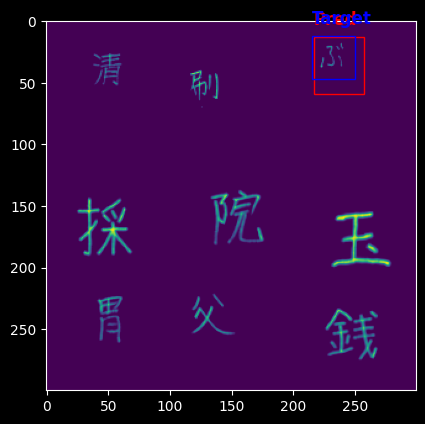

['ず', 'よ', 'は', 'り', 'し', 'み', 'り', 'ほ', 'ぴ', 'に', 'す', 'ろ', 'け', 'ゃ', 'さ', 'や']
pred_class = 20.0
target_class = 20.0


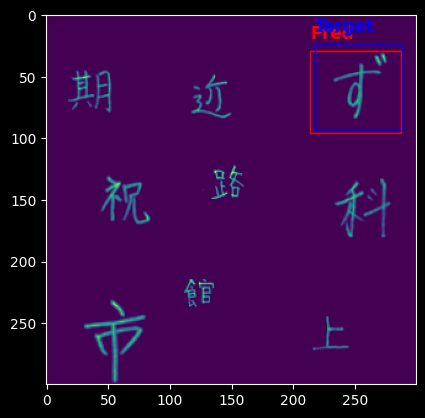

['せ', 'ご', 'ぎ', 'わ', 'だ', 'め', 'し', 'ば', 'ゅ', 'う', 'り', 'を', 'を', 'ぶ', 'お', 'ぶ']
pred_class = 21.0
target_class = 21.0


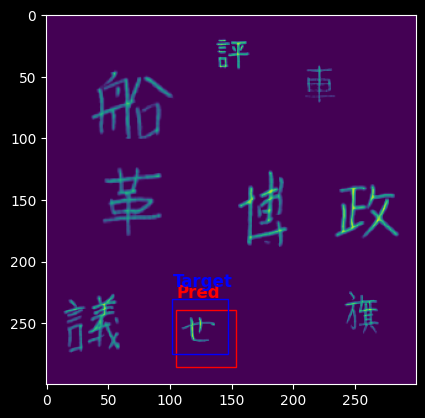

['が', 'り', 'ょ', 'れ', 'ぢ', 'ず', 'ず', 'ぐ', 'ぽ', 'や', 'ぽ', 'た', 'ゆ', 'そ', 'ご', 'ぷ']
pred_class = 6.0
target_class = 6.0


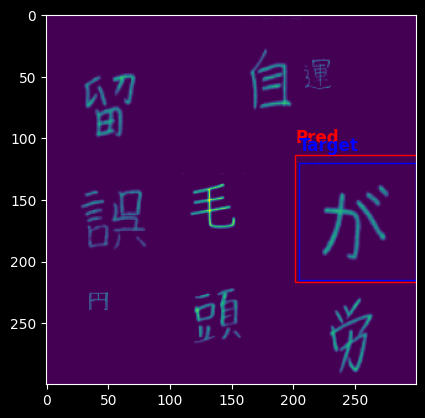

['め', 'ん', 'な', 'む', 'ゆ', 'ろ', 'ゆ', 'ろ', 'と', 'せ', 'げ', 'へ', 'ぽ', 'べ', 'ん', 'ぴ']
pred_class = 59.0
target_class = 59.0


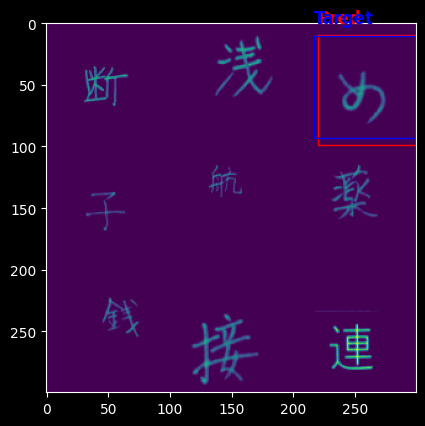

['く', 'み', 'ぞ', 'け', 'し', 'ぷ', 'ぱ', 'ず', 'や', 'ど', 'ま', 'ぺ', 'じ', 'ぱ', 'ぬ', 'む']
pred_class = 9.0
target_class = 9.0


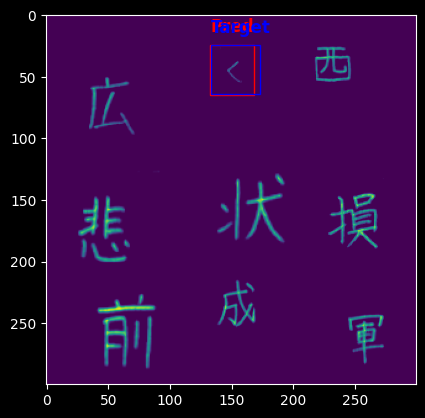

In [15]:
i = 0
num_image = 5
for train_img, train_label, train_moji in train_loader:
    print(train_moji)
    i += 1
    train_img = train_img.to(DEVICE)
    for idx in range(1): # First image of each batch
        pred_bboxes = cellboxes_to_boxes(model(train_img), S, B, C)
        pred_bboxes = non_max_suppression(pred_bboxes[idx], iou_threshold, box_format="midpoint")
        print(f"pred_class = {pred_bboxes[0][0]}")

        target_bboxes = cellboxes_to_boxes(train_label, S, B, C)
        target_bboxes = non_max_suppression(target_bboxes[idx], iou_threshold, box_format="midpoint")
        print(f"target_class = {target_bboxes[0][0]}")

        image = train_img[idx].permute(1,2,0).to("cpu")
        #print(f"image = {image.size()}")

        # Plot the image with predicted and target bounding boxes
        plot_image_pred_target(image, pred_bboxes, target_bboxes)

    if i > num_image:
        break

['ど', 'ぶ', 'ょ', 'い', 'そ', 'ぱ', 'だ', 'き', 'む', 'え', 'ほ', 'め', 'ぞ', 'で', 'し', 'な']
pred_class = 13.0
target_class = 35.0


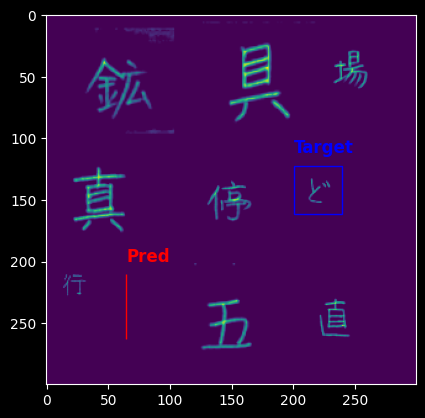

['き', 'む', 'ろ', 'で', 'ぺ', 'て', 'ぞ', 'お', 'ぼ', 'ら', 'く', 'ど', 'ぼ', 'ょ', 'ぞ', 'あ']
pred_class = 63.0
target_class = 7.0


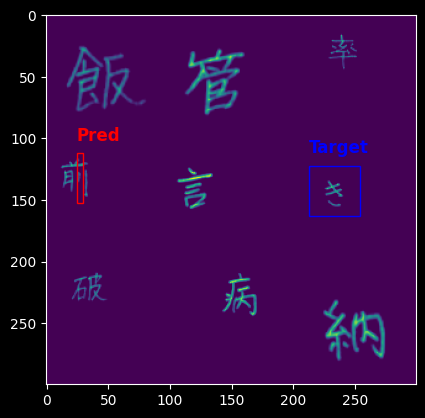

['ざ', 'で', 'あ', 'ろ', 'や', 'ふ', 'き', 'っ', 'ぶ', 'で', 'ら', 'わ', 'ふ', 'む', 'で', 'づ']
pred_class = 60.0
target_class = 16.0


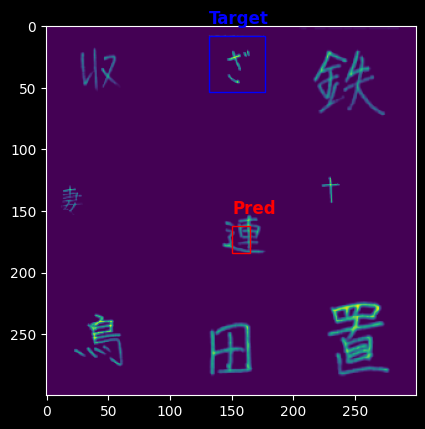

['し', 'ほ', 'べ', 'ば', 'び', 'か', 'ぺ', 'く', 'っ', 'う', 'が', 'う', 'ぶ', 'づ', 'わ', 'ぱ']
pred_class = 71.0
target_class = 17.0


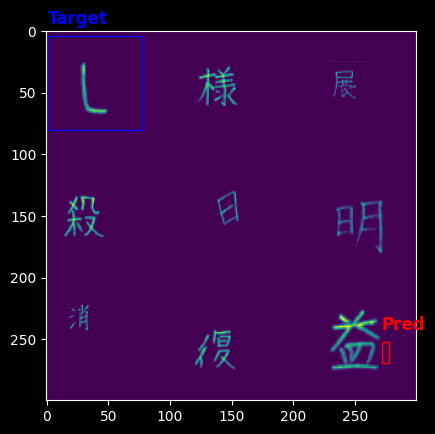

['え', 'ば', 'ぜ', 'た', 'さ', 'え', 'り', 'え', 'と', 'て', 'れ', 'み', 'た', 'う', 'あ', 'こ']
pred_class = 1.0
target_class = 3.0


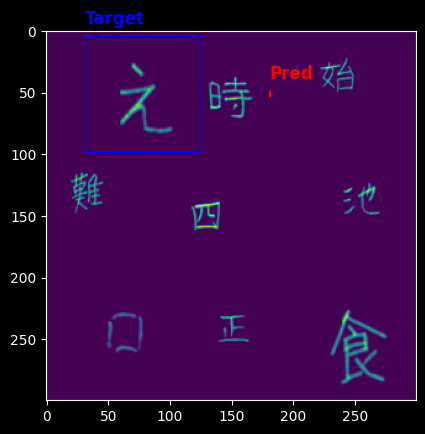

['ち', 'ぞ', 'ぺ', 'む', 'ぎ', 'が', 'ぺ', 'ほ', 'が', 'ぬ', 'め', 'む', 'ず', 'お', 'ふ', 'ざ']
pred_class = 62.0
target_class = 27.0


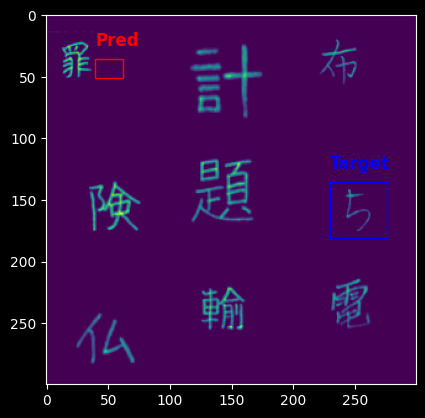

In [16]:
i = 0
num_image = 5
for test_img, test_label, test_moji in test_loader:
    print(test_moji)
    i += 1
    test_img = test_img.to(DEVICE)
    for idx in range(1): # First image of each batch
        pred_bboxes = cellboxes_to_boxes(model(test_img), S, B, C)
        pred_bboxes = non_max_suppression(pred_bboxes[idx], iou_threshold, box_format="midpoint")
        print(f"pred_class = {pred_bboxes[0][0]}")

        target_bboxes = cellboxes_to_boxes(test_label, S, B, C)
        target_bboxes = non_max_suppression(target_bboxes[idx], iou_threshold, box_format="midpoint")
        print(f"target_class = {target_bboxes[0][0]}")

        image = test_img[idx].permute(1,2,0).to("cpu")
        # print(f"image = {image.size()}")

        # Plot the image with predicted and target bounding boxes
        plot_image_pred_target(image, pred_bboxes, target_bboxes)

    if i > num_image:
        break